# Libraries

In [14]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Fuzzy Input/Output Variables

In [15]:
# Inputs
temperature = ctrl.Antecedent(np.arange(-44, 86, 1), 'temperature')      # °C
humidity = ctrl.Antecedent(np.arange(0, 101, 1), 'humidity')     # %
feeling = ctrl.Antecedent(np.arange(0, 11, 1), 'feeling')        # 0=cold ... 10=hot
ecology = ctrl.Antecedent(np.arange(0, 11, 1), 'ecology')        # 0=very ecologically concerned ... 10=not concerned by ecology

# Output
heat = ctrl.Consequent(np.arange(0, 51, 1), 'heat')       # heating level °C

# It's gonna show us to which temperature we should heat/cool the room.

# Membership Functions

In [16]:
room = 'living room'

In [17]:
def temp_membership_func(var, b1, c1, s1, m1, s2, m2, s3 ,m3, b2, c2):
    # for the b parameter we set the mean of our data and for c the standard deviation, even though this is not totally accurate and we would need a curve fitting, we think these are relatively acceptable parameters
    var['too cold']    = fuzz.sigmf(var.universe, b=b1,  c=-c1)
    var['chilly']    = fuzz.gaussmf(var.universe, sigma=s1,  mean=m1)
    var['comfortable']  = fuzz.gaussmf(var.universe, sigma=s2,  mean=m2)
    var['rather hot']     = fuzz.gaussmf(var.universe, sigma=s3,  mean=m3)
    var['too hot']     = fuzz.sigmf(var.universe, b=b2,  c=c2)


In [18]:
if room == 'bathroom':
    temp_membership_func(temperature, 15.38, 2.73, 2.60, 17.75, 1.91, 21.75, 2.10, 25.88, 28.68, 1.69)
    temp_membership_func(heat, 15.38, 2.73, 2.60, 17.75, 1.91, 21.75, 2.10, 25.88, 28.68, 1.69)

elif room == 'kitchen':
    temp_membership_func(temperature, 12.75, 3.49, 3.14, 16.88, 3.55, 21.00, 3.98, 25.19, 28.25, 4.37)
    temp_membership_func(heat, 12.75, 3.49, 3.14, 16.88, 3.55, 21.00, 3.98, 25.19, 28.25, 4.37)

elif room == 'bedroom':
    temp_membership_func(temperature, 13.39, 4.68, 4.06, 15.59, 3.08, 18.83, 2.76, 23.11, 25.08, 2.46)
    temp_membership_func(heat, 13.39, 4.68, 4.06, 15.59, 3.08, 18.83, 2.76, 23.11, 25.08, 2.46)

else: # room in living room or any other room (standard)
    temp_membership_func(temperature, 13.00, 3.16, 2.67, 17.62, 2.91, 21.07, 4.49, 22.77, 27.50, 4.66)
    temp_membership_func(heat, 13.00, 3.16, 2.67, 17.62, 2.91, 21.07, 4.49, 22.77, 27.50, 4.66)



# according to https://atmotube.com/blog/ideal-household-humidity-level, a good humidity for inside is 40-50% --> 45% should be optimal
humidity['low']    = fuzz.trapmf(humidity.universe, [0, 0, 0, 45])
humidity['ok']     = fuzz.trimf(humidity.universe, [0, 45, 100])
humidity['high']   = fuzz.trapmf(humidity.universe, [45, 100, 100, 100])

feeling['too cold']    = fuzz.trapmf(feeling.universe, [0, 0, 0, 5])
feeling['okay']   = fuzz.trimf(feeling.universe, [0, 5, 10])
feeling['too hot']     = fuzz.trapmf(feeling.universe, [5, 10, 10, 10])

ecology['not eco']    = fuzz.trapmf(ecology.universe, [0, 0, 0, 5])
ecology['medium']   = fuzz.trimf(ecology.universe, [0, 5, 10])
ecology['eco']     = fuzz.trapmf(ecology.universe, [5, 10, 10, 10])




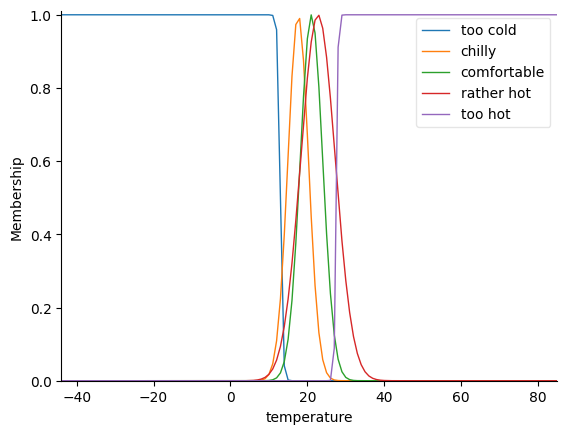

In [19]:
temperature.view()

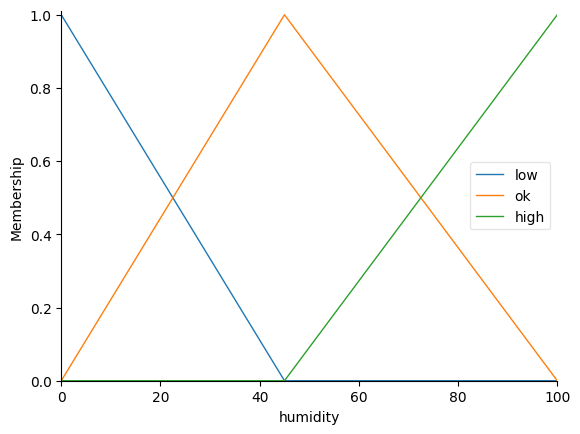

In [20]:
humidity.view()

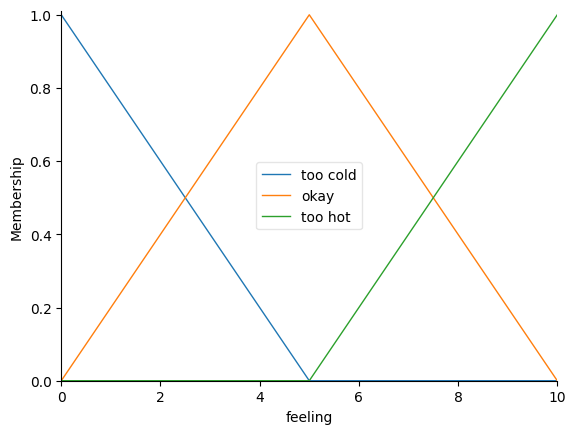

In [21]:
feeling.view()

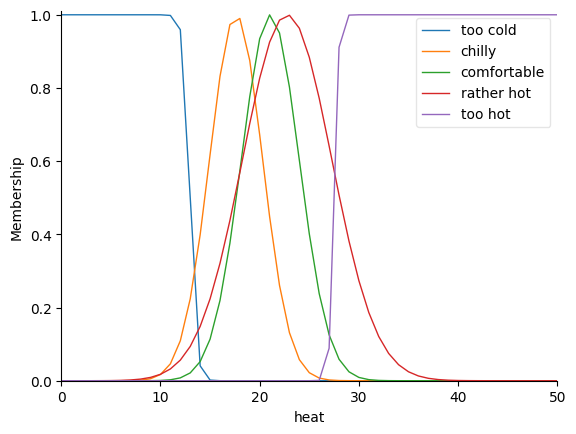

In [22]:
heat.view()

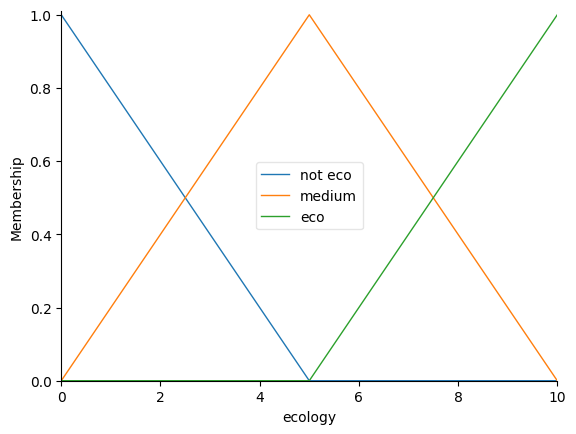

In [23]:
ecology.view()

# Rules

In [24]:
# FUZZY RULE SET 
# "target" means the tempature that system desired.

# A) User feels too cold → raise the target temperature
rule1  = ctrl.Rule(feeling['too cold'] & ecology['not eco'],heat['rather hot'])      
# user feels very cold and ecology is not a concern so choose a warmer target

rule2  = ctrl.Rule(feeling['too cold'] & ecology['medium'],heat['comfortable'])      
# user feels cold but ecology matters somewhat so increase target moderately

rule3  = ctrl.Rule(feeling['too cold'] & ecology['eco'],heat['comfortable'])      
# even with eco preference, keep the target at a comfortable level

# If both the room and the user are cold as a result increase target further
rule4  = ctrl.Rule(temperature['too cold'] & feeling['too cold'],heat['rather hot'])      
# cold room + cold feeling so set a warmer target


# B) User feels okay so stay near comfortable, eco slightly lowers target
rule5  = ctrl.Rule(feeling['okay'] & temperature['comfortable'] & ecology['not eco'],heat['comfortable'])      
# everything is normal so keep the target comfortable

rule6  = ctrl.Rule(feeling['okay'] & temperature['comfortable'] & ecology['medium'],heat['chilly'])      
# medium eco preference so choose a slightly cooler target

rule7  = ctrl.Rule(feeling['okay'] & temperature['comfortable'] & ecology['eco'],heat['chilly'])      
# eco preference so prefer a cooler target


# If the room is a bit cold but the user feels okay as a result raise target slightly
rule8  = ctrl.Rule(feeling['okay'] & temperature['chilly'],heat['comfortable'])      
# chilly room but user is okay so target should be slightly warmer


# If the room is warm while the user feels okay so lower target a bit
rule9  = ctrl.Rule(feeling['okay'] & temperature['rather hot'],heat['chilly'])      
# user is okay but room is somewhat hot so choose a cooler target


# If the room is too hot as a result significantly lower the target
rule10 = ctrl.Rule(feeling['okay'] & temperature['too hot'],heat['too cold'])      
# room is too hot so choose the coldest target


# C) Humidity effect: high humidity makes cold feel colder
rule11 = ctrl.Rule(temperature['chilly'] & humidity['high'] & feeling['okay'],heat['comfortable'])     
# humidity exaggerates cold so raise target slightly


# D) User feels too hot so lower the target temperature
rule12 = ctrl.Rule(feeling['too hot'],heat['too cold'])      
# user is too hot so choose the coldest target


# E) Sensor-based safety rules
rule13 = ctrl.Rule(temperature['too hot'],heat['too cold'])      
# extremely hot room so force target down

rule14 = ctrl.Rule(ecology['eco'] & temperature['rather hot'],heat['too cold'])     
# eco preference + warm room so push target down further


# control system
heating_ctrl = ctrl.ControlSystem([
    rule1, rule2, rule3, rule4,
    rule5, rule6, rule7, rule8, rule9, rule10,
    rule11, rule12, rule13, rule14
])

heating_sim = ctrl.ControlSystemSimulation(heating_ctrl)

In [25]:
# ===== TEST SIMULATION EXAMPLE =====

# Example scenario:
# - living room, membership already defined above
# - temperature: 18°C (a bit cold)
# - humidity: 60% (slightly humid)
# - feeling: 3/10 (closer to 'too cold' region, but overlapping with 'okay')
# - ecology: 2/10 (eco-friendly)

heating_sim.input['temperature'] = 25
heating_sim.input['humidity'] = 60
heating_sim.input['feeling'] = 2
heating_sim.input['ecology'] = 5

heating_sim.compute()
print("Computed heat output:", heating_sim.output['heat'])

Computed heat output: 19.868558610416926


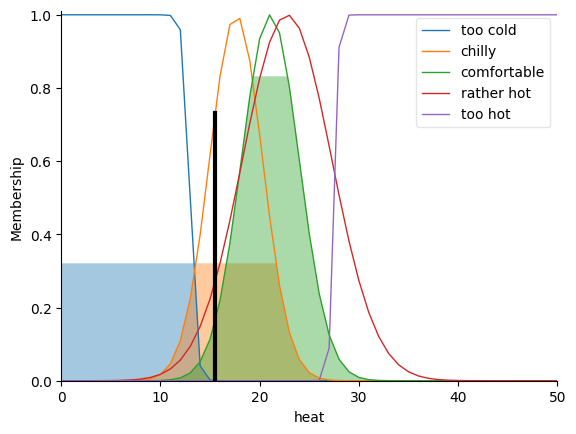

In [13]:
heat.view(sim=heating_sim)

# System and Helper Function

# Some Tests